# Import

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Reference Data

In [79]:
CLUB_NAME_HISTORY = {
    "Thunder FC":"Thunder FC", "Thunder United FC":"Thunder FC", "Real FC United Thunder":"Thunder FC",
    "One Love FC": "One Love FC",
    "Carlos Auto Repair": "Carlos Auto Repair",
    "The Escape Room":"The Escape Room", "The Escapees":"The Escape Room", "Escape Room":"The Escape Room",
    "APEX Charters Lone Pine Brewing":"Lone Pine", "Jibe/Lone Pine":"Lone Pine", "Envy Construction":"Lone Pine",
    "Farmers FC": "Farmers FC",
    "Baxter Pines FC": "Baxter Pines FC",
    "Old Port FC": "Old Port FC",
    "U Gonna Learn Today": "U Gonna Learn Today",
    "Duppy Conquerors": "Duppy Conquerors",
    "Heartbreakers FC": "Heartbreakers FC",
    "Portland Phoenix FC": "Portland Phoenix FC",
    "Midcoast": "Midcoast",
    "The Real Portland Timbers": "The Real Portland Timbers",
    "JW Group": "JW Group",
    "Yankee Ford Sporting Club": "Yankee Ford Sporting Club"
}
LAST_PARTICIPATED_YEARS = {
    "Thunder FC": 2024,
    "One Love FC": 2024,
    "Carlos Auto Repair": 2024,
    "The Escape Room": 2024,
    "Lone Pine": 2024,
    "Farmers FC": 2024,
    "Baxter Pines FC": 2024,
    "Old Port FC": 2024,
    "U Gonna Learn Today": 2023,
    "Duppy Conquerors": 2023,
    "Heartbreakers FC": 2023,
    "Portland Phoenix FC": 2022,
    "Midcoast": 2021,
    "The Real Portland Timbers": 2021,
    "JW Group": 2021,
    "Yankee Ford Sporting Club": 2021
}
KAPPA = 2

In [80]:
Elo_ratings = dict()

dfs = pd.read_excel("data/smusl-stats.xlsx", sheet_name=None)

header = ["Date"]+list(set(CLUB_NAME_HISTORY.values()))
df_Elo_ratings = pd.DataFrame(columns=header)

In [81]:
def calculate_G(home_score: int, away_score: int) -> float:
    '''
    A number from the index of goal differences
    '''
    diff = abs(home_score - away_score)
    if diff <= 1: return 1
    elif diff == 2: return 1.5
    else: return (11+diff) / 8

def calculate_K(week: str) -> int:
    '''
    Weight index regarding the tournament of the match
    '''
    if week.startswith("Week"): return 40
    elif week.startswith("Quarter"): return 50
    elif week.startswith("Semi"): return 60
    else: return 80

def calculate_W(home_score: int, away_score: int) -> float:
    '''
    The result of the match
    '''
    if home_score > away_score: return 1
    elif home_score < away_score: return 0
    else: return 0.5

def calculate_delta(r, kappa=2, s=400):
    return 10**(r/s) / (10**(-r/s) + kappa + 10**(r/s))

def round_to_nearest_even(num):
    ceil_num = math.ceil(num)
    floor_num = math.floor(num)
    return ceil_num if ceil_num - num < 0.5 else floor_num

## Sort by date and add statistics columns

In [82]:
for year in ["2021", "2022", "2023", "2024"]:
    sheet = f"{year}-Match"
    df = dfs[sheet]
    for i in range(len(df.index)):
        row = df.iloc[i]
        month = row["Month"]
        date = row["Date"]
        today_date = pd.to_datetime(f"{year}-{month}-{date}").date()
        df.at[i, "Date"] = today_date
    
    df.sort_values("Date", inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)

    df.insert(len(df.columns), "Elo +/-", [0]*len(df.index))
    df.insert(len(df.columns), "Home Elo", [0]*len(df.index))
    df.insert(len(df.columns), "Away Elo", [0]*len(df.index))
    df.insert(len(df.columns), "Win", [0]*len(df.index))
    df.insert(len(df.columns), "Draw", [0]*len(df.index))
    df.insert(len(df.columns), "Lose", [0]*len(df.index))

# Calculate the Elo rating

In [83]:
idx = -1
for year in ["2021", "2022", "2023", "2024"]:
    zeroth_date = pd.to_datetime(f"{year}-{6}-{1}").date()

    # Check whether the Elo rating exist for each team, if not set it to 1500
    for team in dfs[f"{year}-Table"]["Team"]:
        team = CLUB_NAME_HISTORY[team]
        if team not in Elo_ratings:
            Elo_ratings[team] = [(zeroth_date, 1500)]
        
    sheet = f"{year}-Match"
    df = dfs[sheet]

    prev_date = zeroth_date
    for i in range(len(df.index)):
        row = df.iloc[i]
        home_team = CLUB_NAME_HISTORY[row['Home']]
        away_team = CLUB_NAME_HISTORY[row['Away']]
        date = row["Date"]
        
        home_team_Elo_rating = Elo_ratings[home_team][-1][1]
        away_team_Elo_rating = Elo_ratings[away_team][-1][1]
        home_team_score = row['Home Score']
        away_team_score = row['Away Score']

        df.at[i, "Home Elo"] = round(home_team_Elo_rating, 2)
        df.at[i, "Away Elo"] = round(away_team_Elo_rating, 2)

        # Calculate the Expected result of the match 
        W_e = 1 / (10**(-(home_team_Elo_rating - away_team_Elo_rating)/400)+1)

        # Calculate the Points Chnage
        K = calculate_K(row["Week"])
        G = calculate_G(home_team_score, away_team_score)
        W = calculate_W(home_team_score, away_team_score)
        P = K*G*(W-W_e)
        df.at[i, "Elo +/-"] = round(P,2)
        
        # log the match odd and the Elo ratings exchange
        r = home_team_Elo_rating - away_team_Elo_rating
        pr_home_win = calculate_delta(r, KAPPA)
        pr_away_win = calculate_delta(-r, KAPPA)

        df.at[i, "Win"] = round_to_nearest_even(pr_home_win * 100)
        df.at[i, "Lose"] = round_to_nearest_even(pr_away_win * 100)
        df.at[i, "Draw"] = 100 - df.at[i, "Win"] - df.at[i, "Lose"]

        # Calculate the new ratings
        new_home_team_Elo_rating = home_team_Elo_rating + P
        new_away_team_Elo_rating = away_team_Elo_rating - P

        Elo_ratings[home_team].append((date, new_home_team_Elo_rating))
        Elo_ratings[away_team].append((date, new_away_team_Elo_rating))

        # fill the df_Elo_ratings
        row_Elo_ratings = {"Date": str(date), home_team: new_home_team_Elo_rating, away_team: new_away_team_Elo_rating}
        if prev_date != date:
            idx += 1
            df_Elo_ratings.loc[idx] = row_Elo_ratings 
        else:
            df_Elo_ratings.at[idx, home_team] = new_home_team_Elo_rating
            df_Elo_ratings.at[idx, away_team] = new_away_team_Elo_rating
        
        prev_date = date

# Fill the gap

In [84]:
joined_teams = dict()
for team in set(CLUB_NAME_HISTORY.values()):
    joined_teams[team] = False 

for i in range(len(df_Elo_ratings.index)):
    for col, _ in df_Elo_ratings.items():
        if col == "Date": continue
        if pd.isna(df_Elo_ratings.at[i, col]) and joined_teams[col] and LAST_PARTICIPATED_YEARS[col] >= int(df_Elo_ratings.at[i, "Date"][:4]):
            df_Elo_ratings.at[i, col] = df_Elo_ratings.at[i-1, col]
        else: 
            joined_teams[col] = True

# Plot

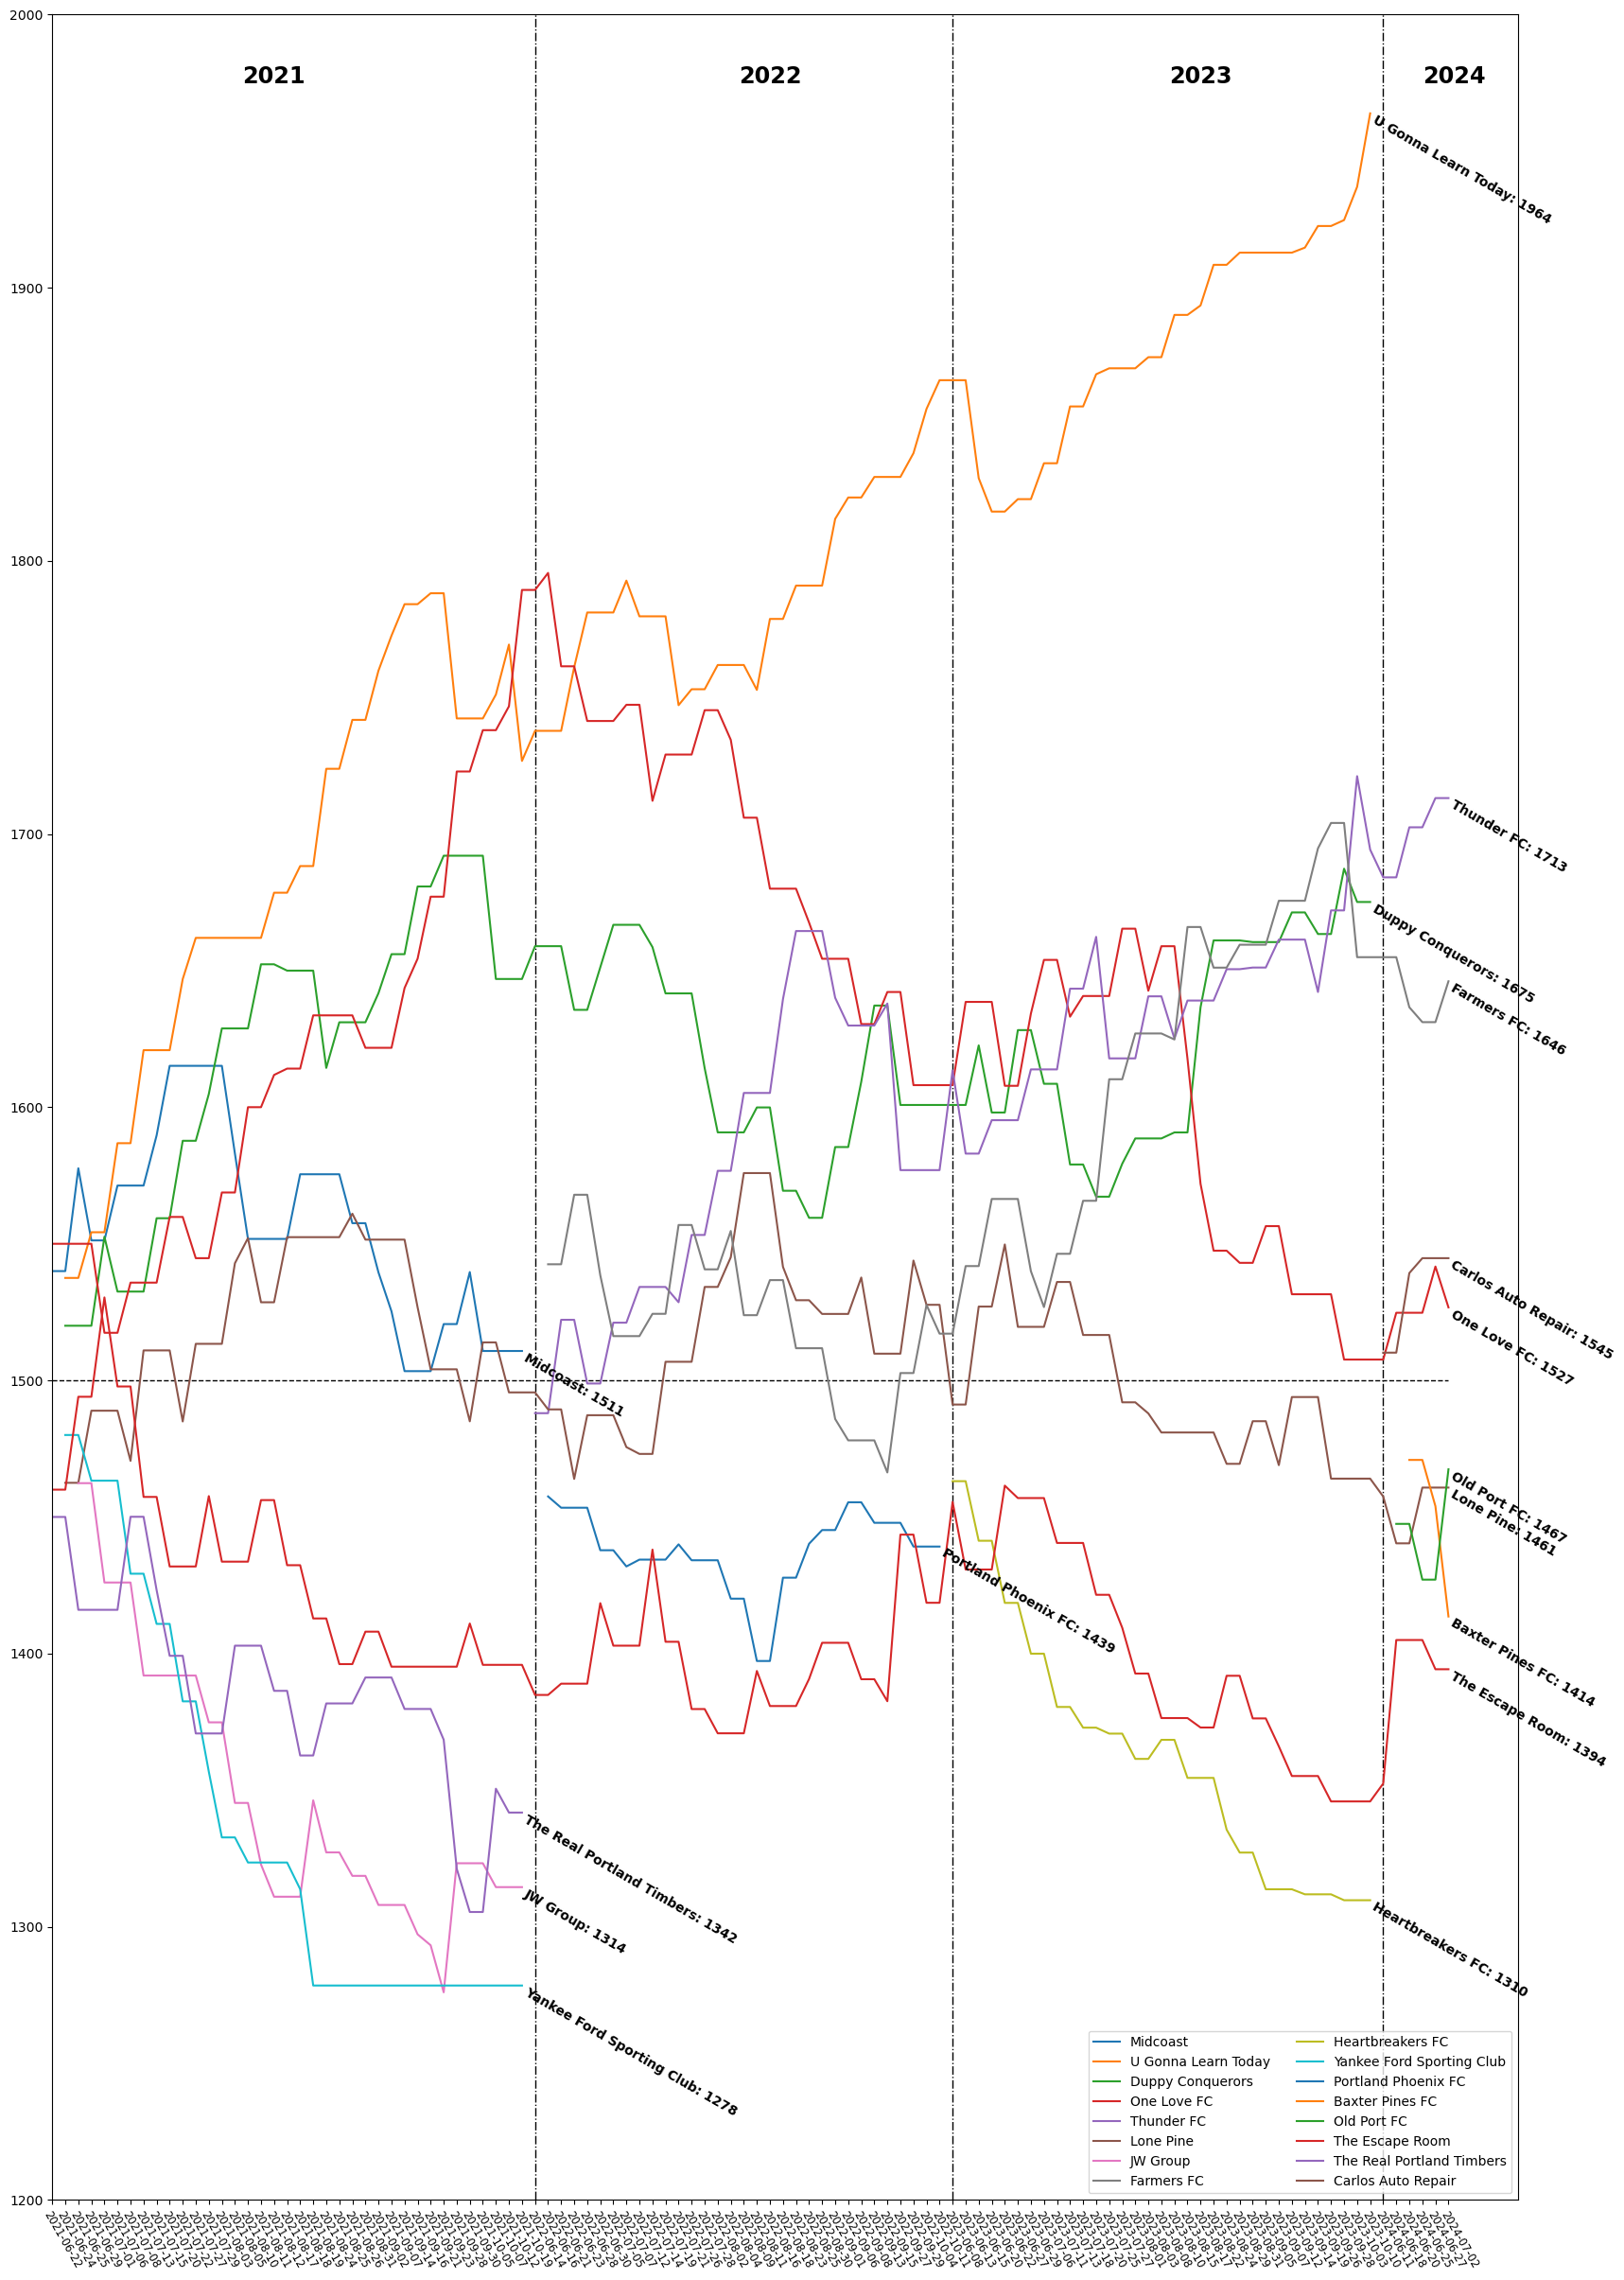

In [85]:
plt.figure(figsize=(20,30))

plt.plot(df_Elo_ratings["Date"], [1500]*len(df_Elo_ratings.index), 'k--', linewidth=1)
plt.axvline(x="2022-06-14", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2023-06-08", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2024-06-11", color = 'k', ls = '-.', linewidth=1)

SEASON_TEXT_Y_COORDINATE = 1975
plt.text("2021-08-12", SEASON_TEXT_Y_COORDINATE, "2021", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2022-08-16", SEASON_TEXT_Y_COORDINATE, "2022", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2023-08-17", SEASON_TEXT_Y_COORDINATE, "2023", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2024-06-25", SEASON_TEXT_Y_COORDINATE, "2024", horizontalalignment='left', weight="bold", fontsize='xx-large')

for col, _ in df_Elo_ratings.items():
    if col == "Date": continue
    plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col)

    for i in range(len(df_Elo_ratings)-1,-1,-1):
        if not pd.isna(df_Elo_ratings.at[i, col]):
            plt.text(df_Elo_ratings.at[i, "Date"], df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", rotation=-30)
            break

_, right = plt.xlim()
plt.xlim(["2021-06-22", right])
plt.ylim([1200, 2000])
plt.legend(loc="lower right", ncol=2)
plt.xticks(rotation=-60, ha="left", rotation_mode="anchor", fontsize="small")
plt.show()

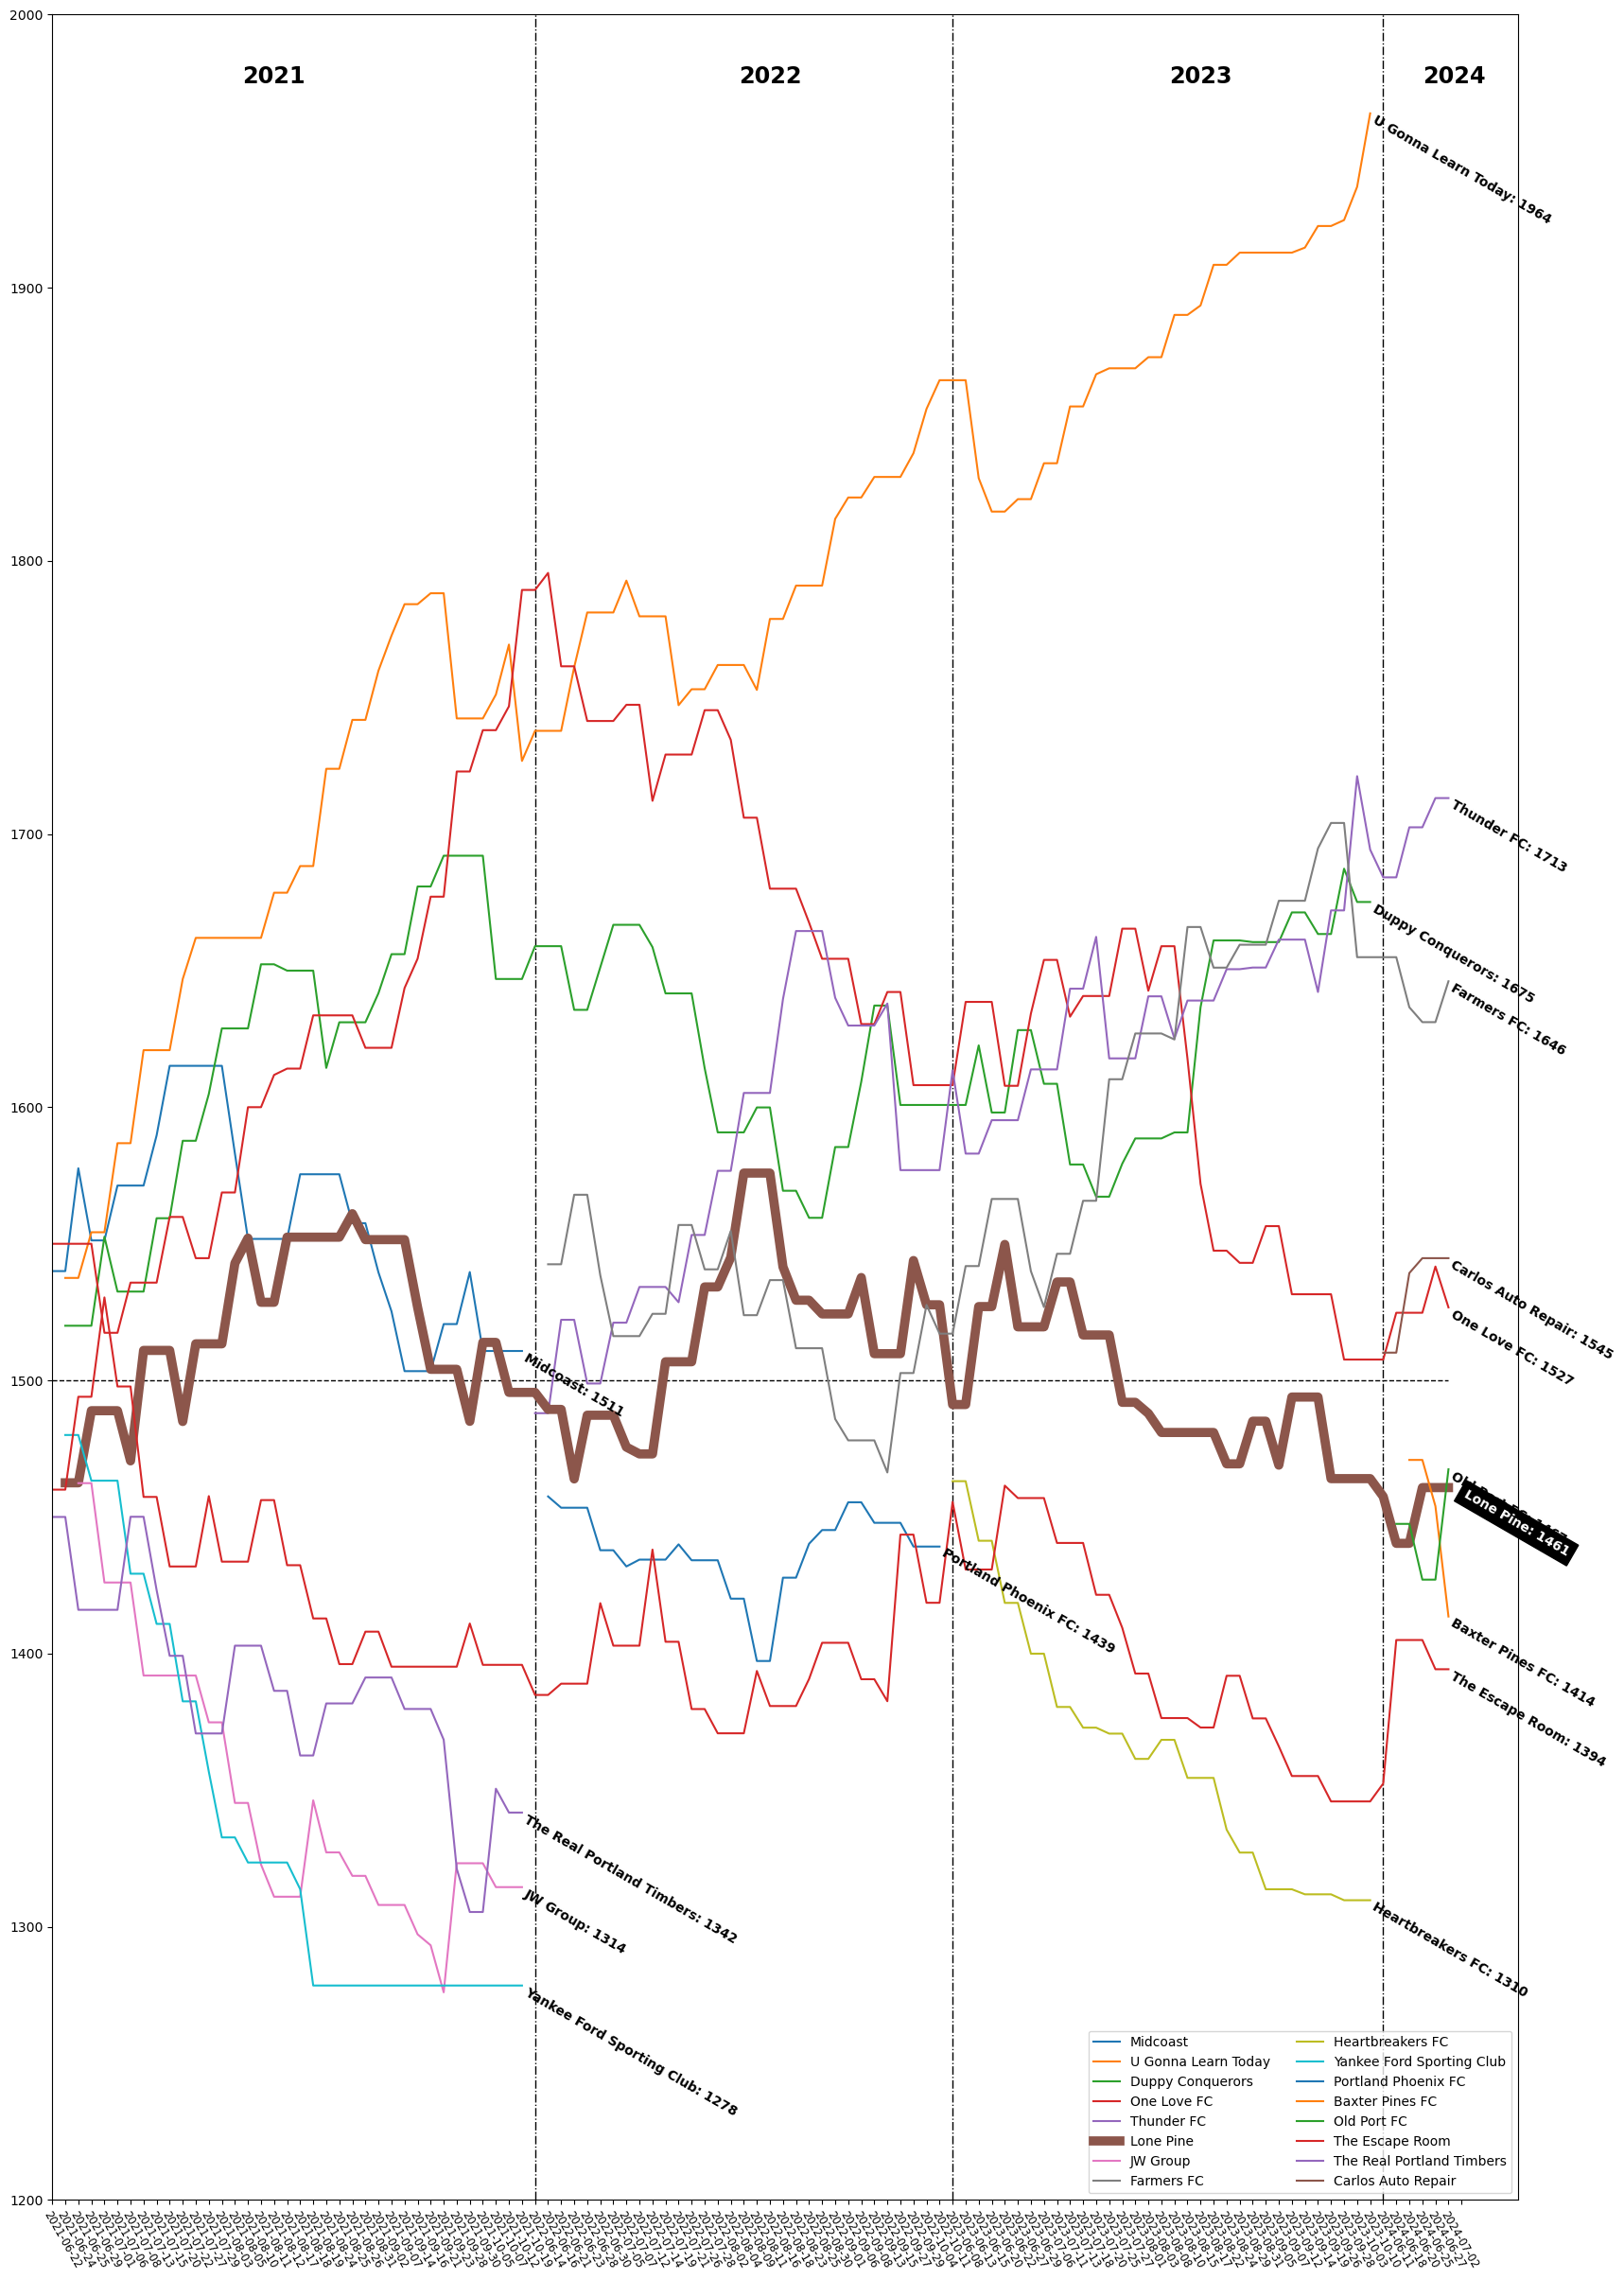

In [86]:
plt.figure(figsize=(20,30))

plt.plot(df_Elo_ratings["Date"], [1500]*len(df_Elo_ratings.index), 'k--', linewidth=1)
plt.axvline(x="2022-06-14", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2023-06-08", color = 'k', ls = '-.', linewidth=1)
plt.axvline(x="2024-06-11", color = 'k', ls = '-.', linewidth=1)

SEASON_TEXT_Y_COORDINATE = 1975
plt.text("2021-08-12", SEASON_TEXT_Y_COORDINATE, "2021", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2022-08-16", SEASON_TEXT_Y_COORDINATE, "2022", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2023-08-17", SEASON_TEXT_Y_COORDINATE, "2023", horizontalalignment='center', weight="bold", fontsize='xx-large')
plt.text("2024-06-25", SEASON_TEXT_Y_COORDINATE, "2024", horizontalalignment='left', weight="bold", fontsize='xx-large')

specific_team = "Lone Pine"
for col, _ in df_Elo_ratings.items():
    if col == "Date": continue
    if col == specific_team: plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col, linewidth=7.0)
    else: plt.plot(df_Elo_ratings["Date"], df_Elo_ratings[col], label=col)

    for i in range(len(df_Elo_ratings)-1,-1,-1):
        if not pd.isna(df_Elo_ratings.at[i, col]):
            if col == specific_team: plt.text("", df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", backgroundcolor = 'black', rotation=-30, color='white')
            else: plt.text(df_Elo_ratings.at[i, "Date"], df_Elo_ratings.at[i, col], f"{col}: {round(df_Elo_ratings.at[i, col])}", verticalalignment='top', weight="bold", rotation=-30)
            break

_, right = plt.xlim()
plt.xlim(["2021-06-22", right])
plt.ylim([1200, 2000])
plt.legend(loc="lower right", ncol=2)
plt.xticks(rotation=-60, ha="left", rotation_mode="anchor", fontsize="small")
plt.show()

In [87]:
Elo_ratings_teams = dict()
for team in Elo_ratings.keys():
    Elo_ratings_teams[team] = round(Elo_ratings[team][-1][1])
for team, rating in sorted(Elo_ratings_teams.items(), key=lambda item: -item[1]):
    print(f"{team : >35}: {rating}")

                U Gonna Learn Today: 1964
                         Thunder FC: 1713
                   Duppy Conquerors: 1675
                         Farmers FC: 1646
                 Carlos Auto Repair: 1545
                        One Love FC: 1527
                           Midcoast: 1511
                        Old Port FC: 1467
                          Lone Pine: 1461
                Portland Phoenix FC: 1439
                    Baxter Pines FC: 1414
                    The Escape Room: 1394
          The Real Portland Timbers: 1342
                           JW Group: 1314
                   Heartbreakers FC: 1310
          Yankee Ford Sporting Club: 1278


## Calculate the biggest upset

In [88]:
matches_list = []
for year in ["2021", "2022", "2023", "2024"]:
    sheet = f"{year}-Match"
    df = dfs[sheet]
    matches_list.append(df)
    
df_all_matches = pd.concat(matches_list)
df_all_matches.sort_values("Elo +/-")[["Date", "Week", "Home", "Away", "Home Elo", "Away Elo", "Win", "Draw", "Lose", "Home Score", "Away Score", "Elo +/-"]].head(10)

,Date,Week,Home,Away,Home Elo,Away Elo,Win,Draw,Lose,Home Score,Away Score,Elo +/-
57,2022-09-27,Quarter-Finals,Real FC United Thunder,Escape Room,1637.95,1382.55,66,31,3,1,3,-60.98
61,2021-09-28,Week 15,The Real Portland Timbers,JW Group,1368.45,1275.98,40,46,14,2,6,-47.25
62,2021-09-28,Week 15,U Gonna Learn Today,One Love FC,1788.14,1677.06,43,45,12,2,5,-45.82
68,2021-10-07,Quarter-Finals,Duppy Conquerors,The Real Portland Timbers,1692.06,1305.39,81,18,1,0,1,-45.13
25,2023-07-25,Week 7,Thunder United FC,Farmers FC,1662.36,1565.74,40,47,13,0,3,-44.49
71,2021-10-19,Final,U Gonna Learn Today,One Love FC,1769.36,1746.75,28,50,22,1,2,-42.60
10,2024-07-02,Week 3,Baxter Pines FC,Old Port FC,1453.95,1427.05,29,50,21,0,4,-40.40
0,2021-06-22,Week 1,The Escape Room,Midcoast,1500.00,1500.00,25,50,25,0,5,-40.00
2,2021-06-24,Week 1,Jibe/Lone Pine,U Gonna Learn Today,1500.00,1500.00,25,50,25,0,4,-37.50
56,2022-09-27,Quarter-Finals,Duppy Conquerors,Farmers FC,1637.21,1466.29,53,40,7,1,2,-36.39


# Calculate the Most Unexpected

In [89]:
cols = ["Win", "Lose"]
df_all_matches.reset_index(inplace=True)
df_all_matches[((df_all_matches["Win"] > df_all_matches["Lose"]) & (df_all_matches["Home Score"] < df_all_matches["Away Score"])) | ((df_all_matches["Win"] < df_all_matches["Lose"]) & (df_all_matches["Home Score"] > df_all_matches["Away Score"]))][["Date", "Week", "Home", "Away", "Home Elo", "Away Elo", "Win", "Draw", "Lose", "Home Score", "Away Score", "Elo +/-"]].assign(_min=df_all_matches[cols].min(axis=1)+df_all_matches["Draw"], _other=df_all_matches[cols].max(axis=1)+df_all_matches["Draw"]).sort_values(["_min","_other"]).drop(columns=["_min","_other"]).head(10)


,Date,Week,Home,Away,Home Elo,Away Elo,Win,Draw,Lose,Home Score,Away Score,Elo +/-
68,2021-10-07,Quarter-Finals,Duppy Conquerors,The Real Portland Timbers,1692.06,1305.39,81,18,1,0,1,-45.13
139,2023-06-15,Week 1,Envy Construction,U Gonna Learn Today,1491.15,1866.13,1,19,80,3,2,35.86
90,2022-07-14,Week 5,One Love FC,Escape Room,1747.31,1402.88,77,22,1,3,4,-35.16
76,2022-06-21,Week 2,Real FC United Thunder,One Love FC,1487.99,1795.57,2,25,73,3,2,34.18
95,2022-07-21,Week 6,Farmers FC,U Gonna Learn Today,1524.36,1779.69,3,31,66,1,0,32.52
129,2022-09-27,Quarter-Finals,Real FC United Thunder,Escape Room,1637.95,1382.55,66,31,3,1,3,-60.98
28,2021-08-05,Week 7,The Real Portland Timbers,Midcoast,1370.75,1615.14,4,31,65,3,2,32.13
143,2023-06-22,Week 2,The Escapees,One Love FC,1430.75,1638.54,5,36,59,2,1,30.71
110,2022-08-18,Week 10,Portland Phoenix FC,Duppy Conquerors,1397.27,1599.91,6,36,58,3,2,30.50
82,2022-06-30,Week 3,Farmers FC,Escape Room,1567.95,1388.97,54,39,7,2,3,-29.48


# Previous Work

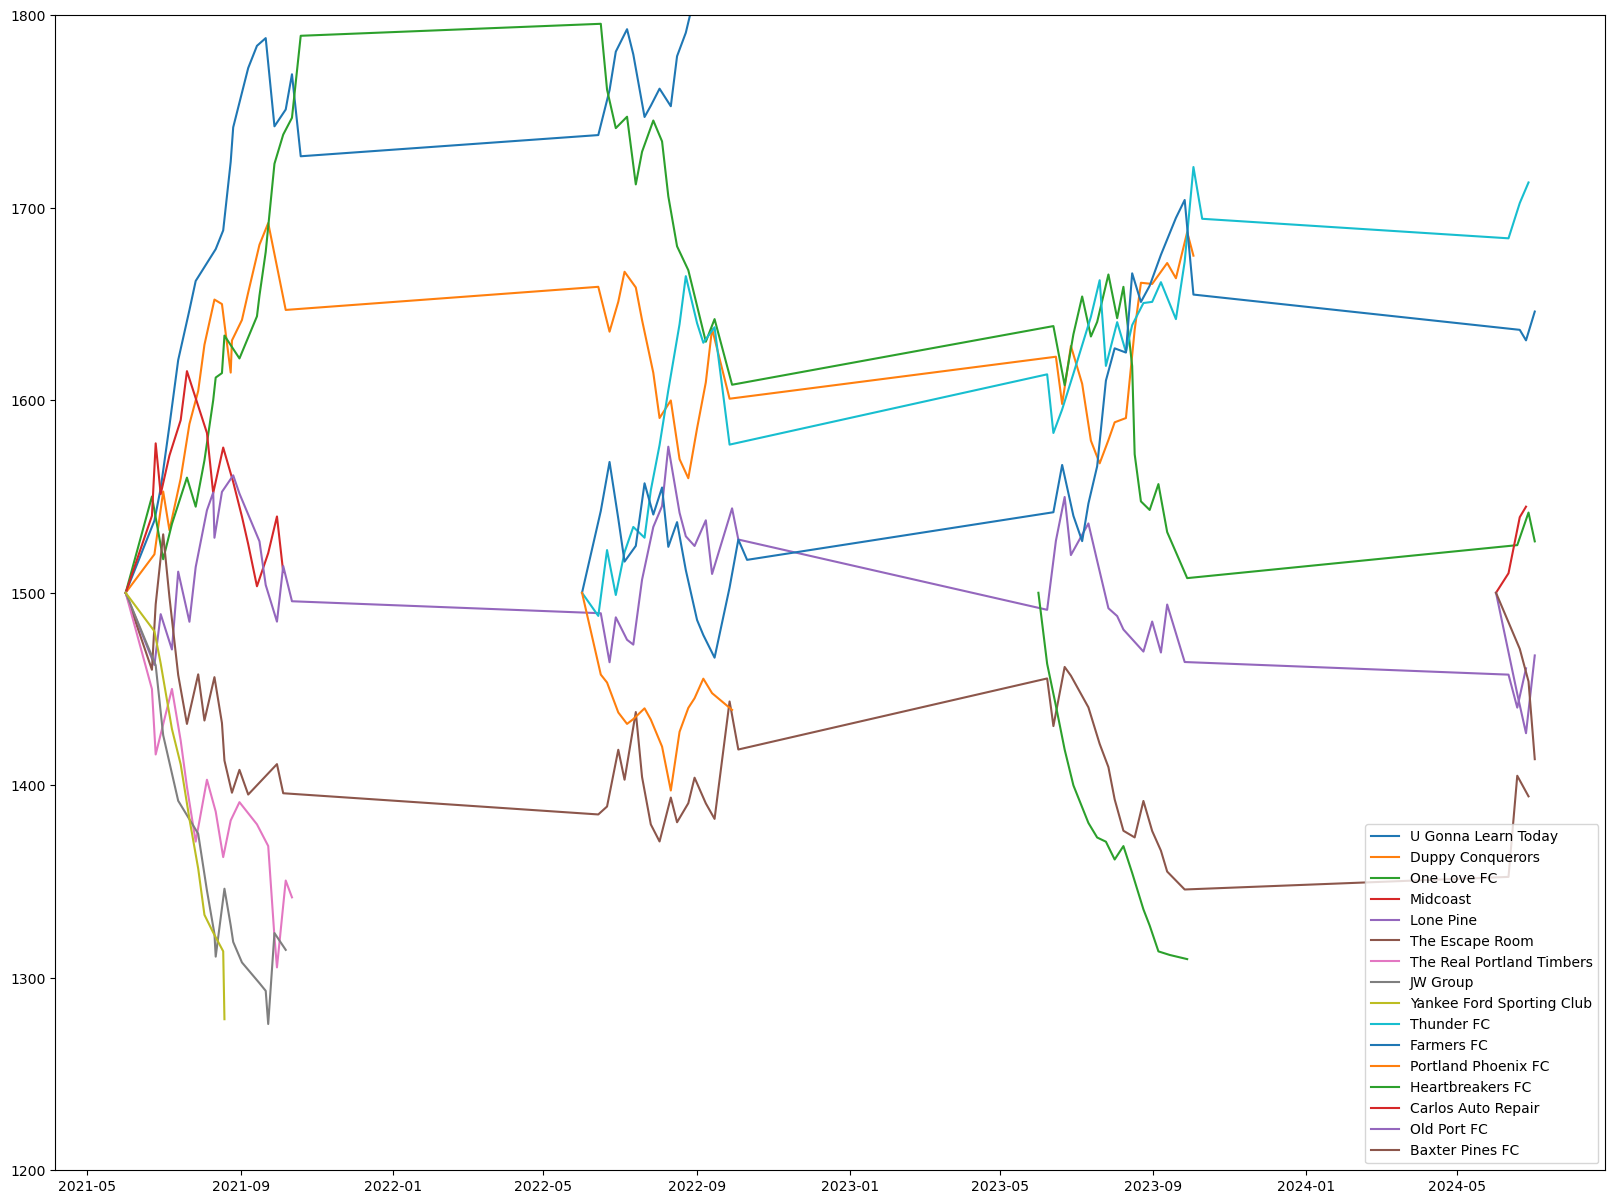

In [90]:
plt.figure(figsize=(20,15))
for team in Elo_ratings.keys():
    Elo_ratings_team = np.array(Elo_ratings[team])
    plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team)
plt.legend(loc="lower right")
plt.ylim(1200, 1800)
plt.show()

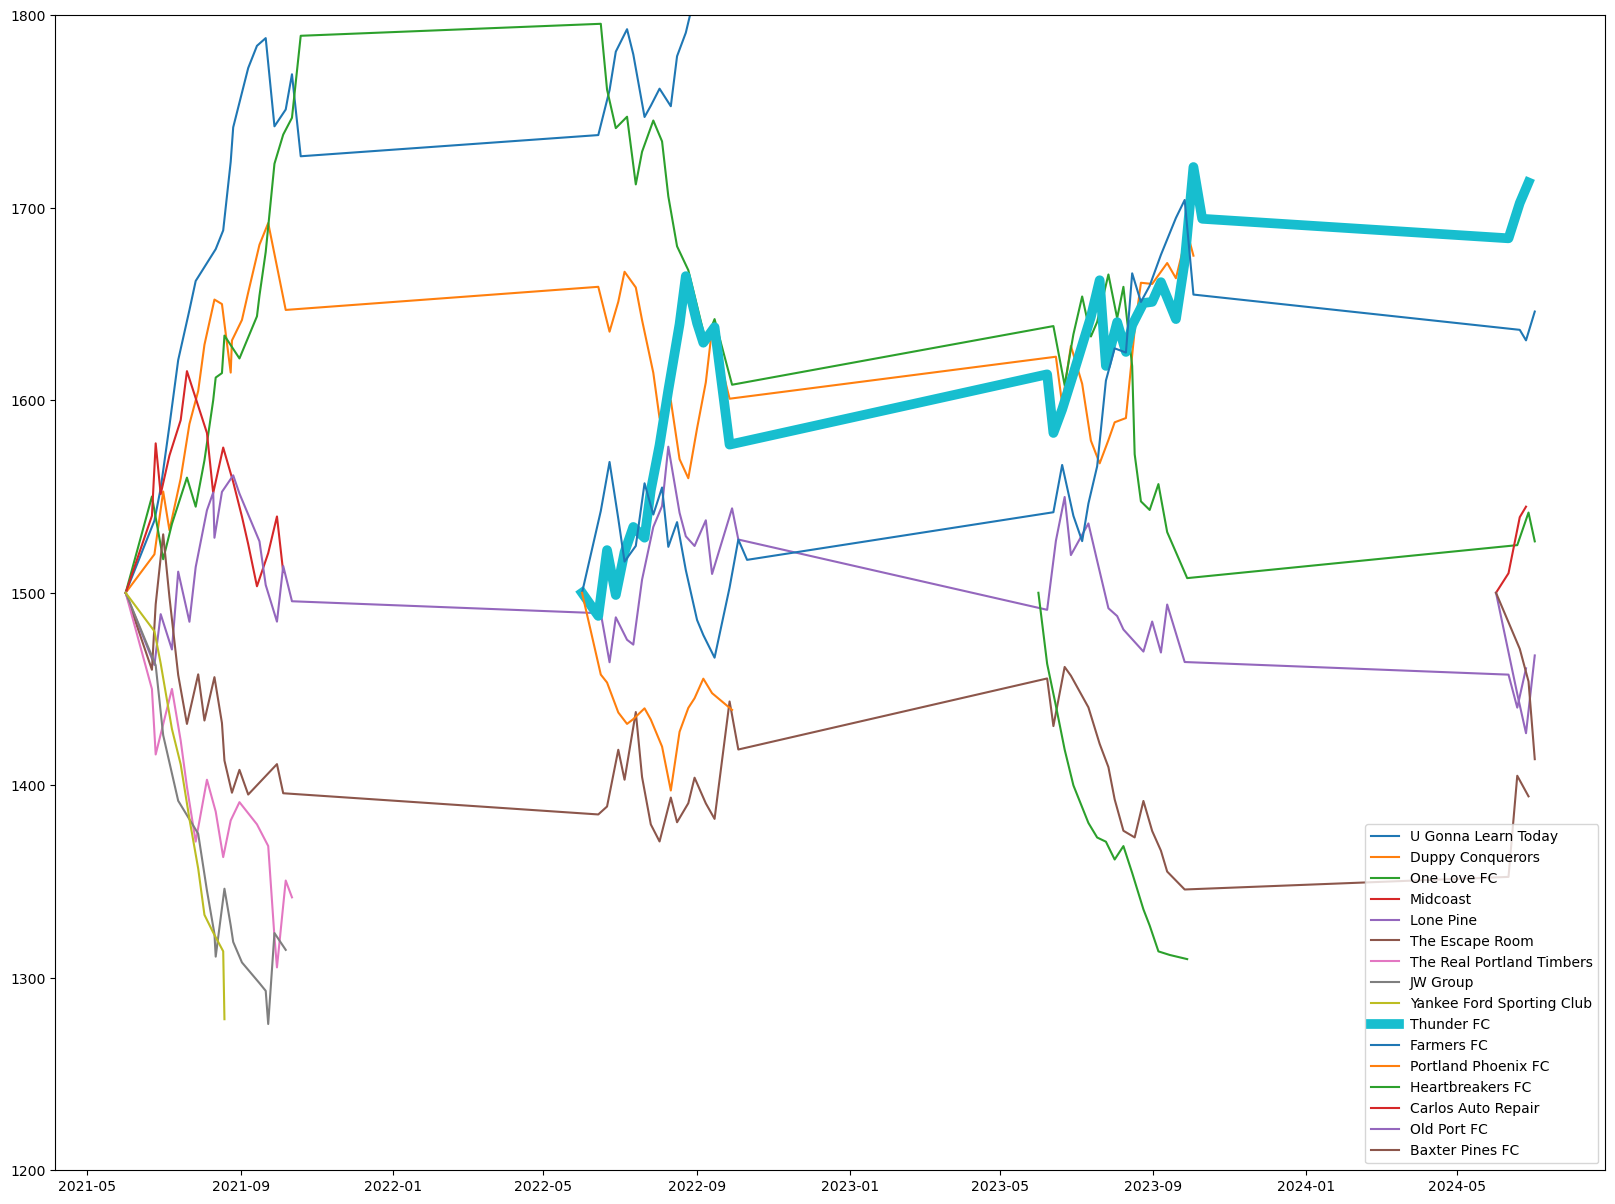

In [91]:
plt.figure(figsize=(20,15))
for team in Elo_ratings.keys():
    Elo_ratings_team = np.array(Elo_ratings[team])
    if team == "Thunder FC":
        plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team, linewidth=7.0)
    else:
        plt.plot(Elo_ratings_team[:,0], Elo_ratings_team[:,1], label=team)
plt.legend(loc="lower right")
plt.ylim(1200, 1800)
plt.show()